# Classification of text sentiment

## Project description

The Wikishop online store is launching a new service. Now users can edit and add product descriptions, just like in wiki communities. That is, clients propose their own edits and comment on the changes of others. The store needs a tool that will look for toxic comments and send them for moderation.

**Task:**
- Train the model to classify comments into positive and negative.

**Important criteria:**
- The value of the F1 metric on the test sample must be at least 0.75.

**Work plan:**
- Loading and preparing data
- Feature preparation and model training
- Summing up the work

**Data description - file `toxic_comments.csv`**

- `text` - text
- `toxic` — text toxicity (`0` - positive; `1` - negative) (***target***)

## Loading and preparing data

Loading the necessary libraries

In [ ]:
%pip install --upgrade scikit-learn
%pip install nltk
%pip install lightgbm
%pip install spacy
%pip install wordcloud


Importing the necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import warnings

import re
import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from wordcloud import WordCloud


# Loading required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc as sklearn_auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Settings

In [3]:
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None) 
tqdm.pandas()

Constants

In [4]:
RANDOM_STATE = 42

Saving the file to a dataframe

In [5]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

Let's look at general information about the dataframe

In [6]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
49576,no change in hysteresis loss,0
4647,niggah \n\nhey fool whyd you delete my article?,1
66815,Please no Wiki-Weirdo posts !,0
65970,japanase translator needed\nthe official timeline is explained here.,0
33879,"Hello, . This message is being sent to inform you that there currently is a discussion at Wikipedia:Administrators' noticeboard/Incidents regarding an issue with which you may have been involved. Thank you.",0


Let's check the number of gaps in the dataframe

In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Let's check the number of complete duplicates in the dataframe

In [8]:
df.duplicated().sum()

0

Let's look at the balance of classes in the file

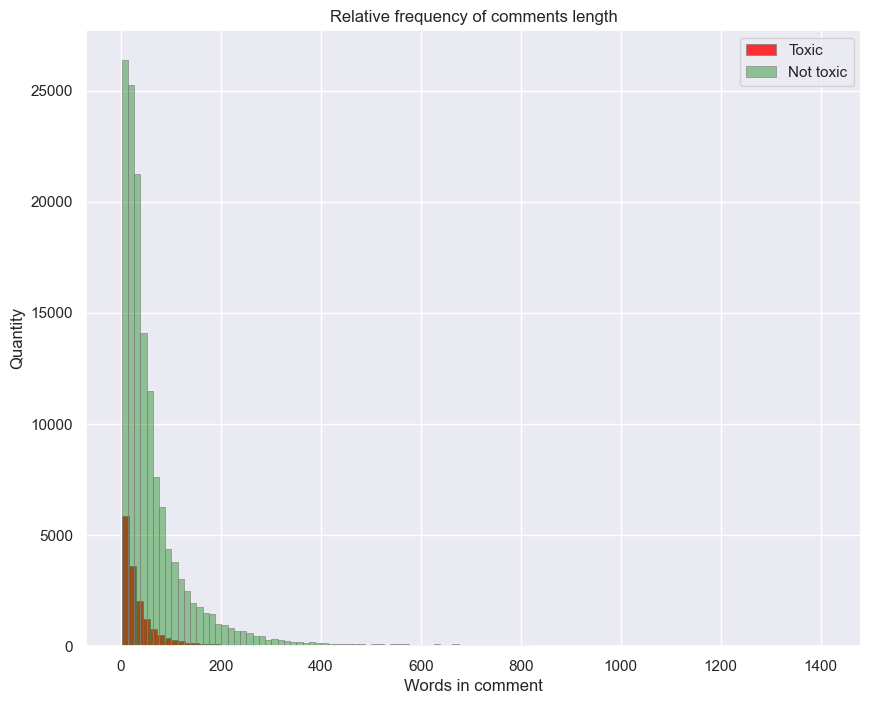

In [9]:
data_graph = df.copy()
data_graph['length_data'] = data_graph.text.apply(lambda x: len(x.split()))
toxic=data_graph.query('toxic == 1')
not_toxic=data_graph.query('toxic == 0')

plt.figure(figsize=(10, 8))

sns.histplot(data=toxic, bins=100, alpha=0.8, edgecolor="gray",color='red', x='length_data')
sns.histplot(data=not_toxic, bins=100, alpha=0.4, edgecolor="gray",  color='green', x='length_data')
plt.title('Relative frequency of comments length')
plt.legend(['Toxic','Not toxic'])
plt.xlabel('Words in comment')
plt.ylabel('Quantity')
plt.show()  

In [10]:
print(df.toxic.value_counts())

toxic
0    143106
1     16186
Name: count, dtype: int64


toxic
Not toxic    143106
Toxic         16186
Name: count, dtype: int64


Text(0.5, 0, 'Count')

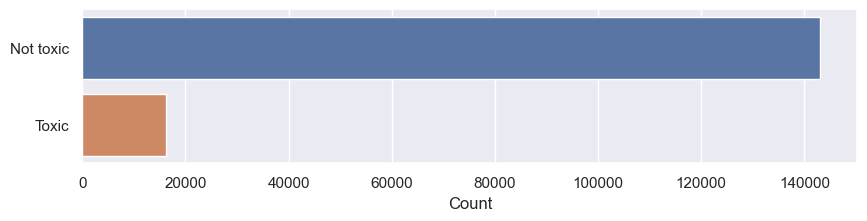

In [11]:
data_graph = df['toxic'].apply(lambda x: 'Toxic' if x == 1 else 'Not toxic').value_counts()
print(data_graph)
plt.figure(figsize=(10, 2))
sns.barplot(x=data_graph.values, y=data_graph.index, orient='h')
plt.ylabel('')
plt.xlabel('Count')

The classes are unbalanced, so we will have to take this into account in the future

## Feature preparation and model training

### Preparing the text

Let's write a function to preprocess our text

In [12]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])
stop_words = set(stopwords.words('english'))

def process_text(text):
    text = re.sub(r'<.*?>', '', text) # Removing HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Cast to lowercase
    text = ' '.join(text.split())   # Remove extra spaces and spaces at the beginning and end of a line
    

    # Using spaCy for tokenization and lemmatization, eliminating stop words
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.text not in stop_words]

    return ' '.join(lemmas)

Applying the function

In [13]:
%%time 
df['text'] = df['text'].progress_apply(process_text)
print(df.head())

  0%|          | 0/159292 [00:00<?, ?it/s]

                                                                                                                                                                                                                                                                                                                                                                           text  \
0                                                                                                                                                                                                explanation edit make username hardcore metallica fan revert not vandalism closure gas vote new york dolls fac please not remove template talk page since retired now892053827   
1                                                                                                                                                                                                                                                                 

Out of curiosity, let's look at frequently occurring words in different comment groups

In [14]:
normal_words = df[df['toxic'] == 0]
toxic_words = df[df['toxic'] == 1]

normal_words = " ".join(word for word in normal_words.text)
toxic_words = " ".join(word for word in toxic_words.text)


In [15]:
wordcloud_normal = WordCloud(max_font_size=40, max_words=50, background_color="black").generate(normal_words)
wordcloud_toxic = WordCloud(max_font_size=40, max_words=50, background_color="black").generate(toxic_words)

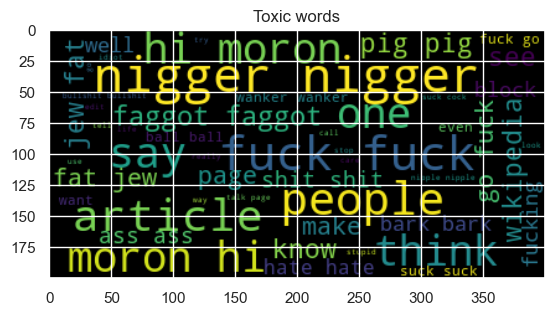

In [16]:
plt.title('Toxic words')
plt.imshow(wordcloud_toxic, interpolation='bilinear')

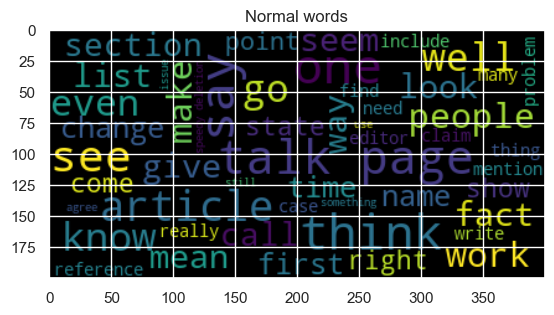

In [17]:
plt.title('Normal words')
plt.imshow(wordcloud_normal, interpolation='bilinear')

Dividing the data into samples

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['toxic'], 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE,

                                                    # Stratify samples by target variable
                                                    stratify=df['toxic'])

### LogisticRegression

Creating a pipeline for our model

In [19]:
pipe_lg = Pipeline([
    ('vct', TfidfVectorizer(stop_words=list(stop_words))),
    ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))
    ])

Creating a grid of parameters for the model

In [20]:
param_grid_lg = {
    'model__C': [0.1, 1, 2, 10]
}

We look at the model metrics on the cross-validation sample

In [21]:
%%time
randomized_search_lg = RandomizedSearchCV(pipe_lg,
                                        param_grid_lg, 
                                          cv=5,
                                        scoring='f1',
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search_lg.fit(X_train, y_train)

CPU times: total: 5.16 s
Wall time: 25.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vct',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'our',
                                                                          'had',
                                                                          'wasn',
                                                                          'from',
                                                                          'here',
                                                                          'few',
                                                                          'has',
                                                                          'too',
                                                                          'then',
                                                                          "aren't",
                                                                          "couldn't",
                                                                          'i',
                                                                          'some',
                                                                          'itself',
                                                                          "you'd",
                                                                          't',
                                                                          'myself',
                                                                          'were',
                                                                          'against',
                                                                          'weren',
                                                                          'me',
                                                                          'hers',
                                                                          'the',
                                                                          'o',
                                                                          'did',
                                                                          'after',
                                                                          "that'll",
                                                                          'up',
                                                                          'as', ...])),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42))]),
                   n_jobs=-1, param_distributions={'model__C': [0.1, 1, 2, 10]},
                   random_state=42, scoring='f1')

We display the results

In [22]:
results_lg = pd.DataFrame(randomized_search_lg.cv_results_)
linear_model_metric = round(randomized_search_lg.best_score_, 2)
# ['mean_fit_time', 'mean_score_time', 'param_C', 'mean_test_score', 'rank_test_score']
display(results_lg[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head(5))

print(f'Best parameters:\n{randomized_search_lg.best_params_}') 
print('F1 Score:', linear_model_metric)


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
3,14.460311,0.676140,{'model__C': 10},0.762700,1
2,13.830322,1.284302,{'model__C': 2},0.756164,2
1,11.860288,1.833395,{'model__C': 1},0.749791,3
0,8.952426,2.127121,{'model__C': 0.1},0.704219,4


Best parameters:
{'model__C': 10}
F1 Score: 0.76


The model with parameter `C` = 10 has F1 metric = 0.76, which is a pretty good result. This model trains in 13 seconds. Let's look at how other models cope with this task

### DecisionTreeClassifier

Let's create a pipeline for the model

In [23]:
pipe_dt = Pipeline([
    ('vct', TfidfVectorizer(stop_words=list(stop_words))),
    ('model', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

Creating a grid of parameters

In [24]:
param_grid_dt = {
    'model__max_depth': [None, 10, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

We train the model on a cross-validation sample, selecting the best parameters

In [25]:
%%time
randomized_search_dt = RandomizedSearchCV(pipe_dt,
                                        param_grid_dt,
                                        cv=5,
                                        scoring='f1',
                                        n_jobs=-1,  
                                        random_state=RANDOM_STATE)

randomized_search_dt.fit(X_train, y_train)

CPU times: total: 38.7 s
Wall time: 3min 31s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vct',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'our',
                                                                          'had',
                                                                          'wasn',
                                                                          'from',
                                                                          'here',
                                                                          'few',
                                                                          'has',
                                                                          'too',
                                                                          'then',
                                                                          "aren't",
                                                                          "couldn't",
                                                                          'i',
                                                                          'some',
                                                                          'itself',
                                                                          "you'd",
                                                                          't',
                                                                          'myself',
                                                                          'were',
                                                                          'against',
                                                                          'weren',
                                                                          'me',
                                                                          'hers',
                                                                          'the',
                                                                          'o',
                                                                          'did',
                                                                          'after',
                                                                          "that'll",
                                                                          'up',
                                                                          'as', ...])),
                                             ('model',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 40],
                                        'model__min_samples_leaf': [1, 2, 5],
                                        'model__min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='f1')

Let's look at the result

In [26]:
results_dt = pd.DataFrame(randomized_search_dt.cv_results_)
dt_model_metric = round(randomized_search_dt.best_score_, 2)

display(results_dt[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head(5))

print(f'Best parameters:\n{randomized_search_dt.best_params_}')   
print('Best F1 Score:', dt_model_metric)

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
3,75.704971,1.416909,"{'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 40}",0.640839,1
9,51.764044,0.998939,"{'model__min_samples_split': 2, 'model__min_samples_leaf': 5, 'model__max_depth': 40}",0.627875,2
4,156.257768,0.514084,"{'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}",0.625558,3
6,20.787771,1.450902,"{'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_depth': 10}",0.575176,4
7,20.698866,1.455183,"{'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 10}",0.575176,4


Best parameters:
{'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 40}
Best F1 Score: 0.64


The best metric for the model is F1 = `0.64`, and the model trains in 76 seconds. A decision tree is definitely not suitable for our task.

### LightGBM

Create a new pipeline for our model

In [27]:
pipe_lgbm = Pipeline([
    ('vct', TfidfVectorizer(stop_words=list(stop_words))),
    ('model', LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

Creating a grid of parameters

In [28]:
param_grid_lgbm = {
    'model__max_depth': [-1, 10, 20],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__num_leaves': [30, 50, 70]
}

In [29]:
%%time
randomized_search_lgbm = RandomizedSearchCV(pipe_lgbm,
                                       param_grid_lgbm,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='f1',
                                       random_state=RANDOM_STATE)

randomized_search_lgbm.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 12140, number of negative: 107329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.737838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511469
[LightGBM] [Info] Number of data points in the train set: 119469, number of used features: 9609
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
CPU times: total: 1min 24s
Wall time: 9min 32s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vct',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'our',
                                                                          'had',
                                                                          'wasn',
                                                                          'from',
                                                                          'here',
                                                                          'few',
                                                                          'has',
                                                                          'too',
                                                                          'then',
                                                                          "aren't",
                                                                          "couldn't",
                                                                          'i',
                                                                          'some',
                                                                          'itself',
                                                                          "you'd",
                                                                          't',
                                                                          'myself',
                                                                          'were',
                                                                          'against',
                                                                          'weren',
                                                                          'me',
                                                                          'hers',
                                                                          'the',
                                                                          'o',
                                                                          'did',
                                                                          'after',
                                                                          "that'll",
                                                                          'up',
                                                                          'as', ...])),
                                             ('model',
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.1,
                                                                 0.2],
                                        'model__max_depth': [-1, 10, 20],
                                        'model__num_leaves': [30, 50, 70]},
                   random_state=42, scoring='f1')

In [30]:
results_lgbm = pd.DataFrame(randomized_search_lgbm.cv_results_)
lgbm_model_metric = round(randomized_search_lgbm.best_score_, 2)

display(results_lgbm[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head(5))

print(f'Best parameters:\n{randomized_search_lgbm.best_params_}')
print('Best F1 Score:', lgbm_model_metric)

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
9,112.579508,1.203389,"{'model__num_leaves': 30, 'model__max_depth': 20, 'model__learning_rate': 0.2}",0.751528,1
3,160.214839,1.907401,"{'model__num_leaves': 30, 'model__max_depth': 10, 'model__learning_rate': 0.2}",0.746894,2
5,298.404439,2.213732,"{'model__num_leaves': 70, 'model__max_depth': -1, 'model__learning_rate': 0.1}",0.746232,3
7,268.213631,2.281732,"{'model__num_leaves': 70, 'model__max_depth': 20, 'model__learning_rate': 0.1}",0.745392,4
6,239.679435,2.109636,"{'model__num_leaves': 50, 'model__max_depth': 20, 'model__learning_rate': 0.1}",0.744314,5


Best parameters:
{'model__num_leaves': 30, 'model__max_depth': 20, 'model__learning_rate': 0.2}
Best F1 Score: 0.75


The model has a good metric F1 = `0.75`, but at the same time it trains in 101 seconds, which is much more than the logical regression model

### Best model

So, the best model turned out to be `LogisticRegression` with parameter `C`=10. Let's see how the model behaves on the test sample

Roc-Auc: 0.97
Accuracy: 0.95
F1 score: 0.77


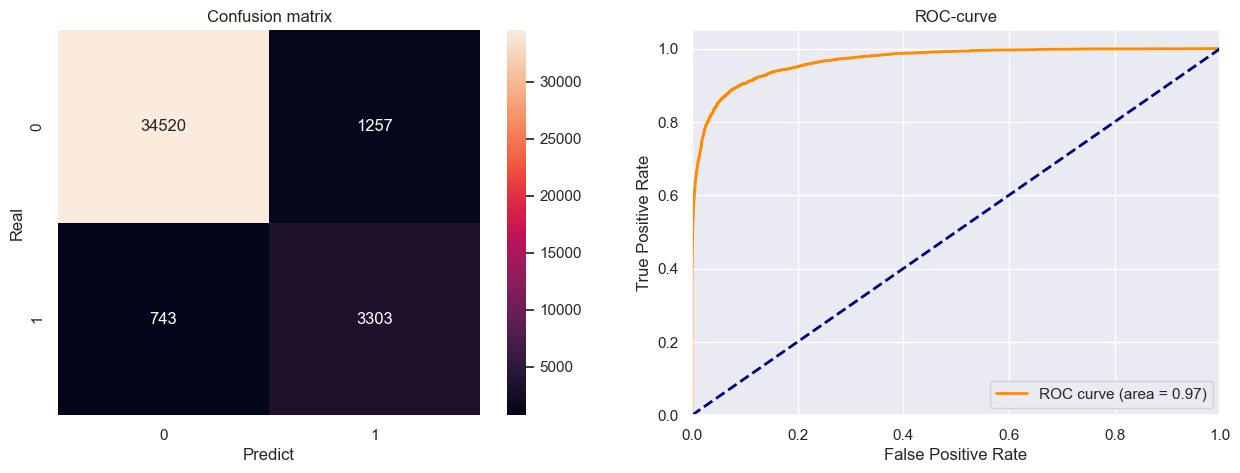

In [31]:
model = randomized_search_lg.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Metrics
auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Roc-Auc:", round(auc, 2))
print("Accuracy:", round(accuracy, 2))
print("F1 score:", round(f1, 2))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Confusion matrix
ax[0] = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=ax[0]) 
ax[0].set_title('Confusion matrix')
ax[0].set_xlabel('Predict')
ax[0].set_ylabel('Real')

# Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = sklearn_auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC-curve')
ax[1].legend(loc="lower right")

plt.show()

- `ROC-AUC (0.97)`: The ROC-AUC value is very high, indicating the excellent ability of the model to distinguish between positive and negative classes. This suggests that the model has good prediction quality.

- `Accuracy (0.95)`: The model correctly predicts 95% of cases. This means that in most cases the model makes the right decision.

- `F1-measure (0.77)`: Although the F1-measure value is slightly lower than other indicators, it is still quite high and passes the customer's criterion. This indicates a good balance between model accuracy and recall, especially in the context of class imbalance.

- `Confusion Matrix`:

   - `True Negatives`: The model correctly predicted 34520 negative cases.
   - `False Positives`: The model incorrectly predicted 1257 cases as positive when they were negative.
   - `False Negatives`: The model missed 743 positive cases, classifying them as negative.
   - `True Positives`: The model correctly identified 3303 positive cases.

### DummyClassifier

Just in case, it’s worth checking how the constant model works to make sure that our model is really useful

In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)

print("F1 score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

F1 score: 0.18445827349609065
Accuracy: 0.10159957813323958


Our model really gets the job done

## Conclusions

### Description of tasks

Our task was to train the model to determine the sentiment of comments.

Criteria that are important to the customer:
- F1-measure not less than `0.75`

### Description of work stages

1. We have downloaded the data
2. Make sure that there are no gaps/duplicates in the file
3. Class imbalance was identified
4. Processed the text, clearing it of unnecessary elements, lemmatizing, tokenizing
5. Converted all comments into vectors
6. Trained three models (`LogisticRegression`, `DecisionTreeClassifier`, `LGBMClassifier`) on the data and determined the best one (based on the customer’s criteria)

### Final conclusions

We tested three models:

- `LogisticRegression` (`C` = 10) - the F1 metric of the model was 0.76, which satisfies the customer’s criterion; the training time of such a model was 12.4 seconds, and the prediction speed was 0.87 seconds

- `DecisionTreeClassifier` (`min_samples_split` = 2, `min_samples_leaf` = 2, `max_depth` = 40) - the F1 metric of the model is 0.64, which does not meet the customer’s criteria; training time - 76 seconds, prediction speed - 1.61 seconds

- `LGBMClassifier` (`num_leaves` = 30, `max_depth` = 20, `learning_rate` = 0.2) - F1-measure was 0.75, which passes the expected threshold; training time of this model is 101.8, prediction speed is 1.46 seconds


`LogisticRegression` with parameter `C` = 10 is the best of the studied models, since it has the best F1 metric in the minimum training and prediction time. Small training time and fast prediction speed can be very important in the context of an online store, where the number of users can be large.
We did not try to improve the metrics of the remaining models, since they trained on data for too long, which is already a big disadvantage compared to the logistic regression model.